# Step 1: Fetch Market Data
Install yfinance library and fetch historical stock data using yfinance. Save the data to the data/raw/ directory.

In [39]:
# Install yfinance library
%pip install yfinance 

#Fetch data from Yahoo Finance
import yfinance as yf # Import yfinance
import pandas as pd # Import pandas

# Fetch data for a specific stock (e.g. AAPL)
ticker = 'AAPL' # Stock ticker
start_date = '2020-01-01' # Start date
end_date = '2023-01-01' # End date

data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']] # Keep only the Close price
data.reset_index(inplace=True) # Reset the index
print(data.head()) # Print the first few rows of the data

import os 

# Create a directory to store the data with subfolder for the ticker and date
directory = f'data/raw/{ticker}_{start_date}_to_{end_date}'
os.makedirs(directory, exist_ok=True)

# Save the data to a CSV file in the subfolder
data.to_csv(f'{directory}/{ticker}_stock_data.csv', index=False)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed

Price        Date      Close
Ticker                  AAPL
0      2020-01-02  75.087502
1      2020-01-03  74.357498
2      2020-01-06  74.949997
3      2020-01-07  74.597504
4      2020-01-08  75.797501


# Step 2: Exploratory Data Analysis (EDA)
Load the dataset, visualize the closing price, check for missing values, and identify trends and seasonality.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    756 non-null    object
 1   Close   757 non-null    object
dtypes: object(2)
memory usage: 12.0+ KB
None


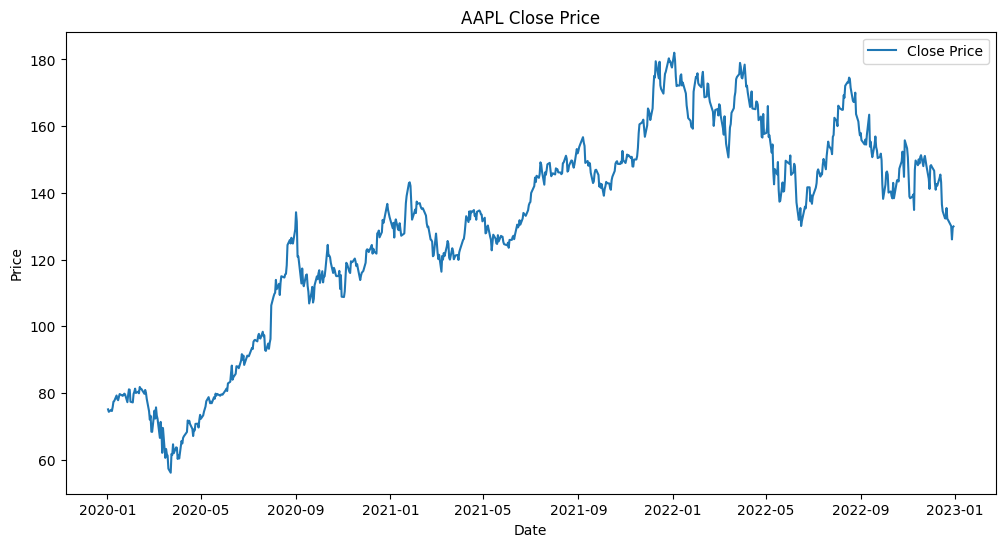

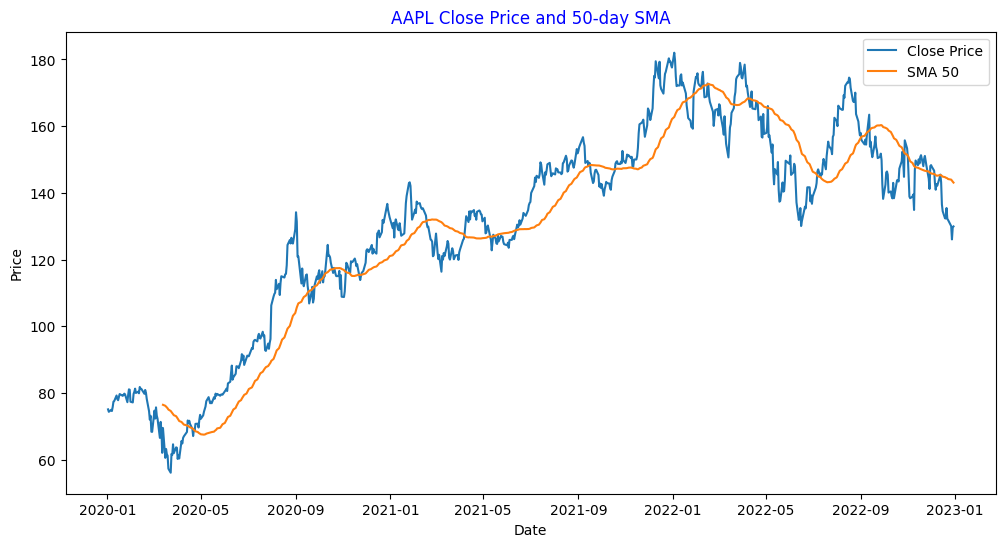

In [40]:
# Info from cell 1
ticker = 'AAPL' # Stock ticker
start_date = '2020-01-01' # Start date
end_date = '2023-01-01' # End date

# Directory where data is stored for loading the dataset
directory = f'data/raw/{ticker}_{start_date}_to_{end_date}'

# Load the dataset
data = pd.read_csv(f'{directory}/{ticker}_stock_data.csv')
print(data.info()) # Print the information about the dataset

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Ensure 'Close' column is numeric
data['Close'] = pd.to_numeric(data['Close'], errors='coerce') # Coerce to NaN if error

# Visualize the closing price
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6)) # Set the figure size
plt.plot(data['Date'], data['Close'], label='Close Price') # Plot the close price
plt.title(f'{ticker} Close Price') # Set the title
plt.xlabel('Date') # Set the x-axis label
plt.ylabel('Price') # Set the y-axis label
plt.legend() # Show the legend
plt.show() # Show the plot

# Check for and count missing values
missing_values = data.isnull().sum()  

# Identify trends and seasonality: Add simple moving averages or rolling means to observe trends
data['SMA_50'] = data['Close'].rolling(window=50).mean() # 50-day moving average
plt.figure(figsize=(12, 6)) # Set the figure size
plt.plot(data['Date'], data['Close'], label='Close Price') # Plot the close price
plt.plot(data['Date'], data['SMA_50'], label='SMA 50') # Plot the 50-day moving average
plt.title(f'{ticker} Close Price and 50-day SMA', color='blue') # Set the title
plt.xlabel('Date') # Set the x-axis label
plt.ylabel('Price') # Set the y-axis label
plt.legend() # Show the legend
plt.show() # Show the plot




# Step 3: Preprocess Data
Convert dates into a numerical format, split the data into input features and target labels, perfrom train-test split, and normalize the data.

In [41]:
from datetime import datetime
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

# Convert dates into a numerical format
data['Date'] = pd.to_datetime(data['Date']) # Convert to datetime
data['Date'] = data['Date'].map(datetime.toordinal) # Convert to ordinal

# Split the data into input features (X) and target labels (y)
X = data['Date'].values.reshape(-1,1) #Reshape for sklearn
y = data['Close'].values

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Normalize the data
scaler = MinMaxScaler() # Create the scaler
y_train = scaler.fit_transform(y_train.reshape(-1,1))
# Fit and transform the data
y_test = scaler.transform(y_test.reshape(-1,1)) # Transform the data


# Step 4: Build Simple Models
Train a Linear Regression model, evaluate the model, and visualize predictions.

Training MSE: 0.0170


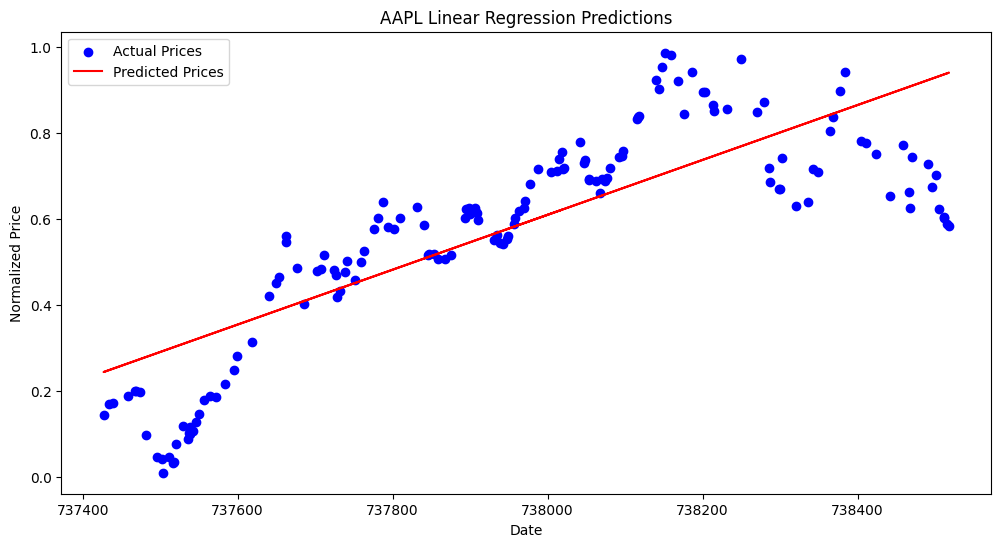

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Remove NaN values from y_train and y_test
non_nan_indices_train = ~np.isnan(y_train).flatten()
non_nan_indices_test = ~np.isnan(y_test).flatten()

X_train_non_nan = X_train[non_nan_indices_train]
y_train_non_nan = y_train[non_nan_indices_train]

X_test_non_nan = X_test[non_nan_indices_test]
y_test_non_nan = y_test[non_nan_indices_test]

# Train a linear regression model
lr = LinearRegression() # Create the model
lr.fit(X_train_non_nan, y_train_non_nan) # Train the model

# Predict on the training and test data
y_pred_train = lr.predict(X_train_non_nan) # Predict on the training data
y_pred_test = lr.predict(X_test_non_nan) # Predict on the test data

# Evaluate the model
mse_train = mean_squared_error(y_train_non_nan, y_pred_train) # Calculate the MSE on the training data
mse_test = mean_squared_error(y_test_non_nan, y_pred_test) # Calculate the MSE on the test data
print(f'Training MSE: {mse_train:.4f}') # Print the training MSE

# Visualize the predictions
plt.figure(figsize=(12, 6)) # Set the figure size
plt.scatter(X_test_non_nan, y_test_non_nan, color='blue', label='Actual Prices') # Plot the training data
plt.plot(X_test_non_nan, y_pred_test, color='red', label='Predicted Prices') # Plot the predictions
plt.title(f'{ticker} Linear Regression Predictions') # Set the title
plt.xlabel('Date') # Set the x-axis label
plt.ylabel('Normalized Price') # Set the y-axis label
plt.legend() # Show the legend
plt.show() # Show the plot

# Step 5: Introduce Complexity - Polynomial Regression
Generate polynomial features, train a polynomial regression model, evaluate the model, and visualize overfitting.

Polynomial Training MSE: 0.0070
Polynomial Test MSE: 0.0080


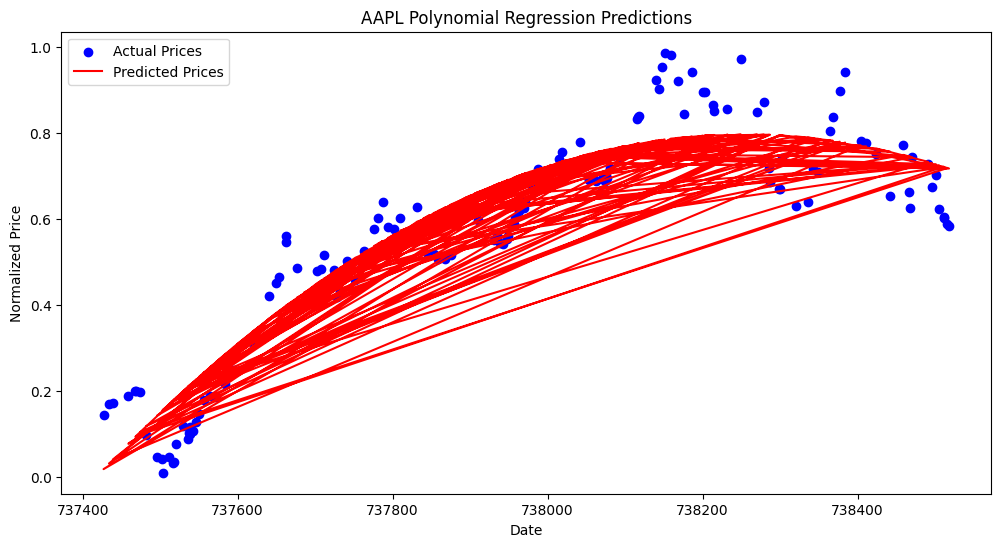

In [43]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=5) # Start with a 5th degree polynomial
X_train_poly = poly.fit_transform(X_train_non_nan) # Transform the training data
X_test_poly = poly.transform(X_test_non_nan) # Transform the test data

# Train a polynomial regression model
poly_lr = LinearRegression() # Create the model
poly_lr.fit(X_train_poly, y_train_non_nan) # Train the model

# Make predictions
y_pred_train_poly = poly_lr.predict(X_train_poly) # Predict on the training data
y_pred_test_poly = poly_lr.predict(X_test_poly) # Predict on the test data

# Evaluate the model
mse_train_poly = mean_squared_error(y_train_non_nan, y_pred_train_poly) # Calculate the MSE on the training data
mse_test_poly = mean_squared_error(y_test_non_nan, y_pred_test_poly) # Calculate the MSE on the test data
print(f'Polynomial Training MSE: {mse_train_poly:.4f}') # Print the training MSE
print(f'Polynomial Test MSE: {mse_test_poly:.4f}') # Print the test MSE

# Visualize the predictions
plt.figure(figsize=(12, 6)) # Set the figure size
plt.scatter(X_test_non_nan, y_test_non_nan, color='blue', label='Actual Prices') # Plot the training data
plt.plot(X_test_non_nan, y_pred_test_poly, color='red', label='Predicted Prices') # Plot the predictions
plt.title(f'{ticker} Polynomial Regression Predictions') # Set the title
plt.xlabel('Date') # Set the x-axis label
plt.ylabel('Normalized Price') # Set the y-axis label
plt.legend() # Show the legend
plt.show() # Show the plot



# Step 6: Mitigate Overfitting - Regularization
Train a Ridge Regression model and compare its performance to the overfit polynomial model.

Ridge Training MSE: 0.0170
Ridge Test MSE: 0.0208


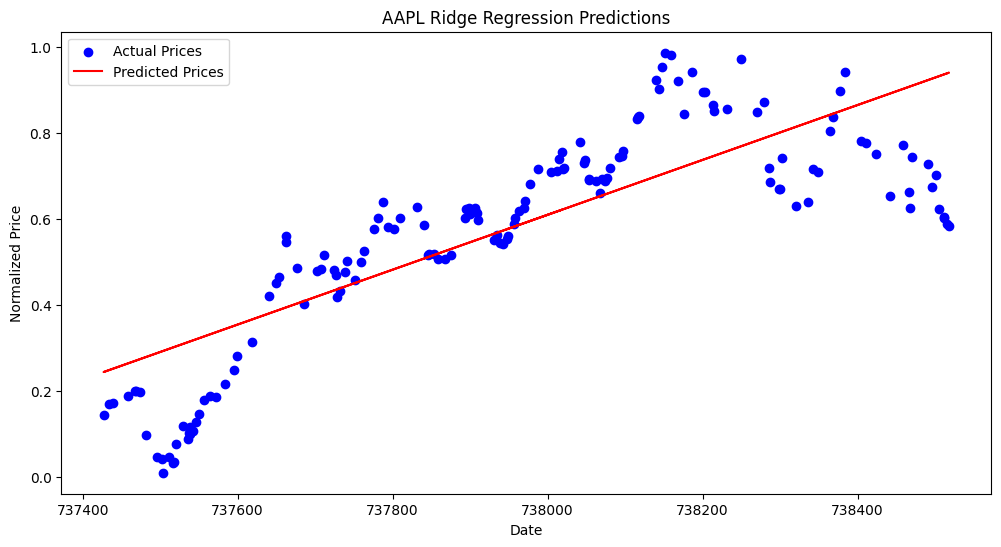

In [44]:
from sklearn.linear_model import Ridge

# Train a Ridge regression model
ridge = Ridge(alpha=0.1) # Create the model
ridge.fit(X_train_non_nan, y_train_non_nan) # Train the model

# Predict on the training and test data
y_pred_train_ridge = ridge.predict(X_train_non_nan) # Predict on the training data
y_pred_test_ridge = ridge.predict(X_test_non_nan) # Predict on the test data

# Evaluate the model
mse_train_ridge = mean_squared_error(y_train_non_nan, y_pred_train_ridge) # Calculate the MSE on the training data
mse_test_ridge = mean_squared_error(y_test_non_nan, y_pred_test_ridge) # Calculate the MSE on the test data
print(f'Ridge Training MSE: {mse_train_ridge:.4f}') # Print the training MSE
print(f'Ridge Test MSE: {mse_test_ridge:.4f}') # Print the test MSE

# Visualize the predictions
plt.figure(figsize=(12, 6)) # Set the figure size
plt.scatter(X_test_non_nan, y_test_non_nan, color='blue', label='Actual Prices') # Plot the training data
plt.plot(X_test_non_nan, y_pred_test_ridge, color='red', label='Predicted Prices') # Plot the predictions
plt.title(f'{ticker} Ridge Regression Predictions') # Set the title
plt.xlabel('Date') # Set the x-axis label
plt.ylabel('Normalized Price') # Set the y-axis label
plt.legend() # Show the legend
plt.show() # Show the plot


# Step 7: Stress-Test Models
Add noise to test data and evaluate model performance on noisy data.

Ridge Noisy Test MSE: 0.0299


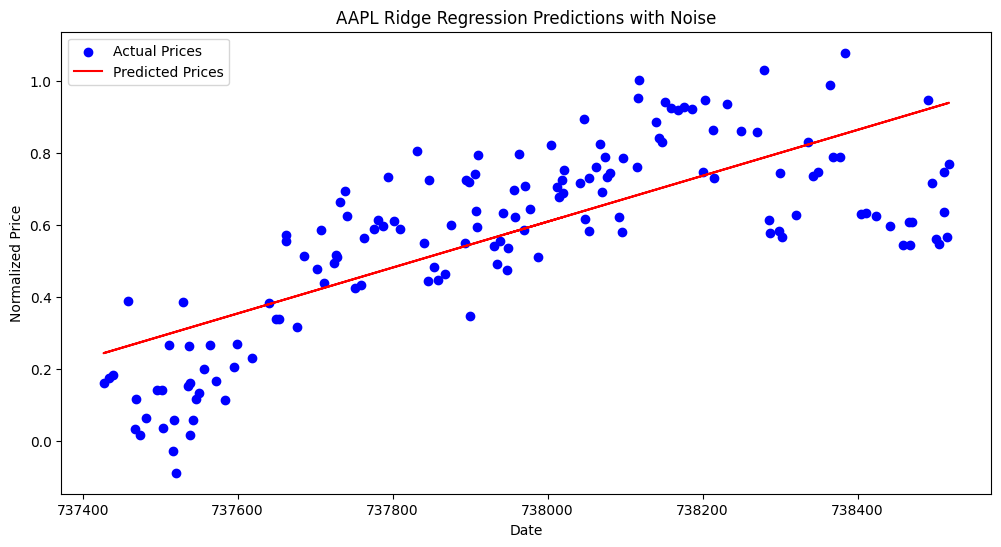

In [45]:
# Add noise to test data
import numpy as np

noise = np.random.normal(0, 0.1, y_test_non_nan.shape) # Generate noise
y_test_noisy = y_test_non_nan + noise # Add noise to the test data

# Evaluate the model with noisy test data
y_pred_test_ridge = ridge.predict(X_test_non_nan) # Predict on the noisy test data
mse_test_noisy = mean_squared_error(y_test_noisy, y_pred_test_ridge) # Calculate the MSE on the noisy test data
print(f'Ridge Noisy Test MSE: {mse_test_noisy:.4f}') # Print the noisy test MSE

# Visualize the predictions
plt.figure(figsize=(12, 6)) # Set the figure size
plt.scatter(X_test_non_nan, y_test_noisy, color='blue', label='Actual Prices') # Plot the training data
plt.plot(X_test_non_nan, y_pred_test_ridge, color='red', label='Predicted Prices') # Plot the predictions
plt.title(f'{ticker} Ridge Regression Predictions with Noise') # Set the title
plt.xlabel('Date') # Set the x-axis label
plt.ylabel('Normalized Price') # Set the y-axis label
plt.legend() # Show the legend
plt.show() # Show the plot


# Step 8: Visualize and Interpret Results
Plot learning curves, summarize findings through graphs and metrics, and save plots.

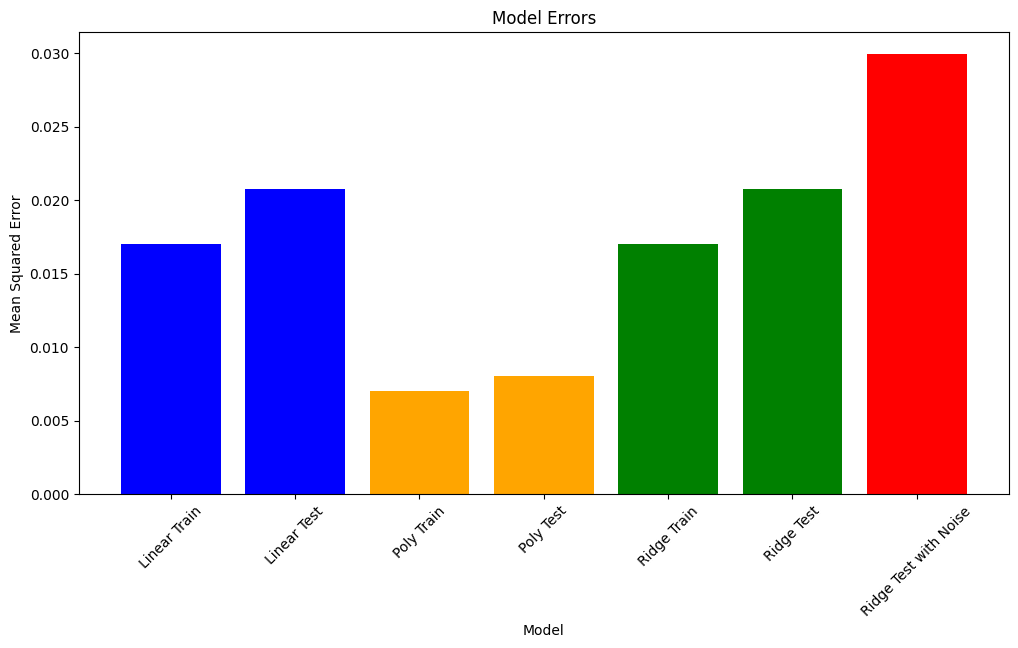

NameError: name 'y_pred_noisy' is not defined

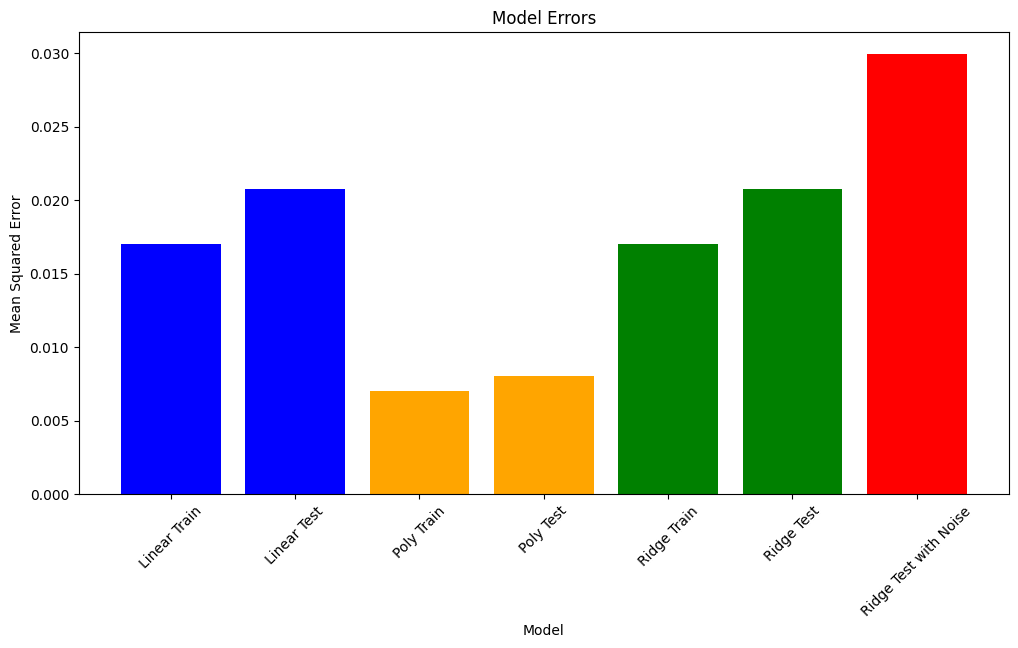

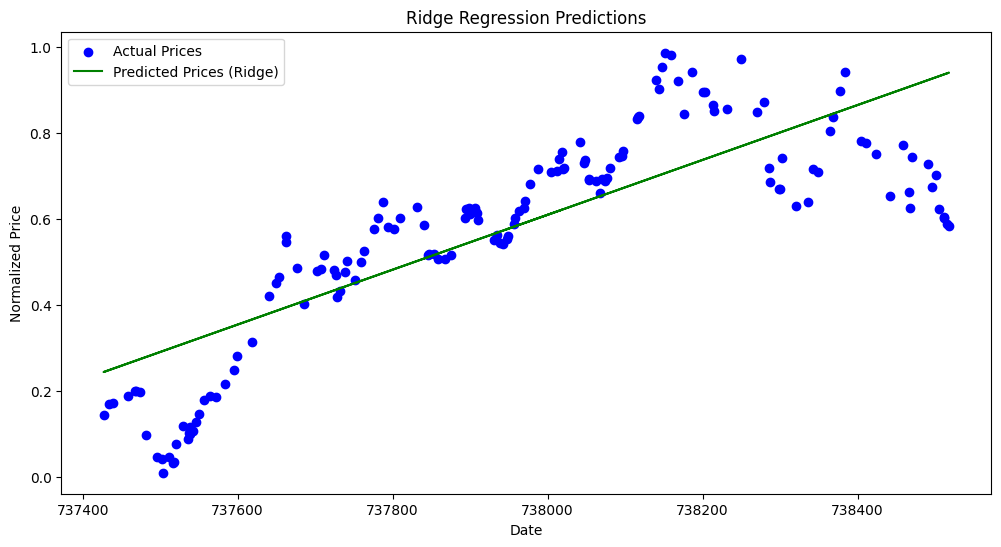

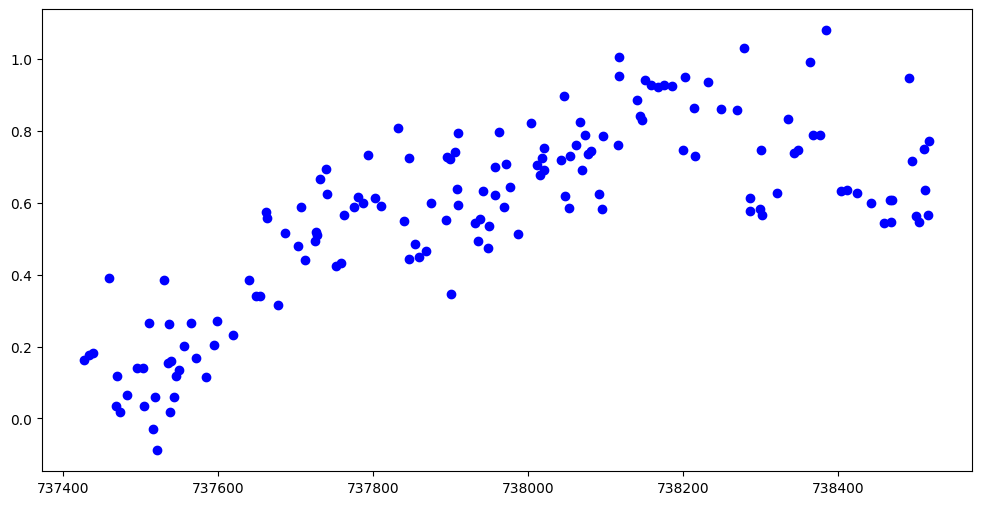

In [46]:
# Plot learning curves: Show training vs. testing error for different models
errors = [mse_train, mse_test, mse_train_poly, mse_test_poly, mse_train_ridge, mse_test_ridge, mse_test_noisy]
labels = ['Linear Train', 'Linear Test', 'Poly Train', 'Poly Test', 'Ridge Train', 'Ridge Test', 'Ridge Test with Noise']

plt.figure(figsize=(12, 6))
plt.bar(labels, errors, color=['blue', 'blue', 'orange', 'orange', 'green', 'green', 'red'])
plt.title('Model Errors')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()

# Save plots to results/plots/ directory
import os

# Create directory if it doesn't exist
os.makedirs('results/plots/', exist_ok=True)

# Save the bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, errors, color=['blue', 'blue', 'orange', 'orange', 'green', 'green', 'red'])
plt.title('Model Errors')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.savefig('results/plots/model_errors.png')

# Save the Ridge Regression predictions plot
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices')
plt.plot(X_test, y_pred_test_ridge, color='green', label='Predicted Prices (Ridge)')
plt.title('Ridge Regression Predictions')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.savefig('results/plots/ridge_regression_predictions.png')

# Save the Ridge Regression predictions with noisy data plot
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test_noisy, color='blue', label='Noisy Actual Prices')
plt.plot(X_test, y_pred_noisy, color='green', label='Predicted Prices (Ridge)')
plt.title('Ridge Regression Predictions with Noisy Data')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.savefig('results/plots/ridge_regression_predictions_noisy.png')
